In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
from scipy.stats import randint

In [4]:
df = pd.read_csv("imputacion_normal_categoricas.csv")
df.head(5)

,esg_score21,esg_class21,environ_score21,environ_class21,social_score21,social_class21,govern_score21,govern_class21,turnover21,firm_age,...,sectors_Metals & Metal Products,"sectors_Public Administration, Education, Health Social Services",sectors_Retail,sectors_Transport Manufacturing,sectors_Utilities,audit_status21_Audit n.a.,audit_status21_Missing,audit_status21_No auditado,audit_status21_Salvedades,audit_status21_Sin opinión
0,-0.569247,-0.345854,-1.721908,-0.231856,-1.041523,-0.34062,0.656902,0.766337,0.966472,-0.992268,...,-0.306401,-0.029774,-0.326808,-0.241562,-0.212202,-0.288945,-1.366672,-0.022077,-0.156524,-0.016303
1,0.534502,-0.345854,0.446051,-0.231856,-0.150737,-0.34062,1.204951,0.766337,1.372254,0.045862,...,-0.306401,-0.029774,3.059904,-0.241562,-0.212202,-0.288945,-1.366672,-0.022077,-0.156524,-0.016303
2,1.454293,2.325055,0.686935,-0.231856,1.096364,-0.34062,2.301049,0.766337,-0.026514,-0.247218,...,-0.306401,-0.029774,3.059904,-0.241562,-0.212202,-0.288945,-1.366672,-0.022077,-0.156524,-0.016303
3,0.166586,-0.345854,-0.637929,-0.231856,-0.328894,-0.34062,0.930926,0.766337,-0.425488,-3.168087,...,-0.306401,-0.029774,-0.326808,-0.241562,-0.212202,-0.288945,-1.366672,-0.022077,-0.156524,-0.016303
4,0.166586,-0.345854,0.084724,-0.231856,-0.685208,-0.34062,1.067939,0.766337,-2.940287,1.331912,...,-0.306401,-0.029774,-0.326808,-0.241562,-0.212202,-0.288945,0.731704,-0.022077,-0.156524,-0.016303


Fitting 2 folds for each of 10 candidates, totalling 20 fits
Mejores parámetros: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 42}
Error cuadrático medio (MSE): 0.0588
Error absoluto medio (MAE): 0.1660
R^2 en test: 0.9406


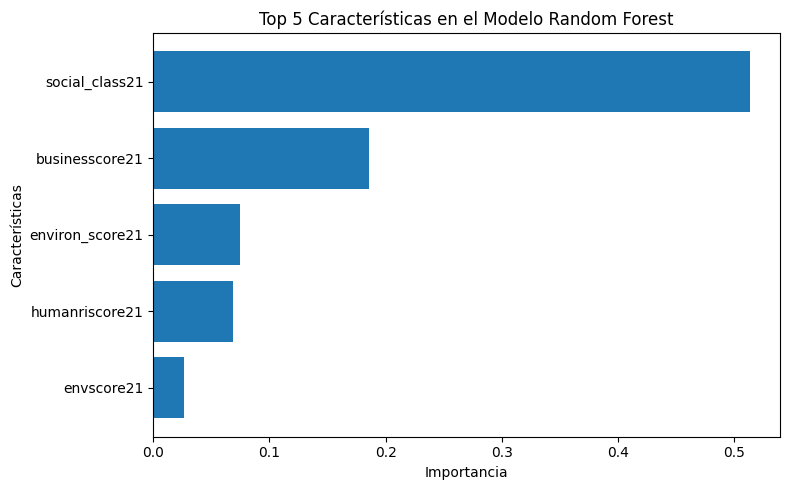

In [12]:
# 1. Cargar y preparar los datos
y = df['social_score21']  # Variable objetivo actualizada
correlations = df.corr()

# Identificar variables correlacionadas
high_corr_features = correlations['social_score21'].abs().sort_values(ascending=False)
variables_correlacionadas = high_corr_features[high_corr_features > 0.8].index.tolist()
variables_correlacionadas.remove('social_score21')

# Eliminar variables altamente correlacionadas
X = df.drop(columns=variables_correlacionadas + ['social_score21'], errors='ignore')

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. Definir Random Forest y RandomizedSearchCV con hiperparámetros reducidos
rf_model = RandomForestRegressor(random_state=42)
param_dist = {
    'n_estimators': randint(10, 50),  # Menor número de árboles
    'max_depth': [5, 10],  # Profundidad limitada
    'min_samples_split': randint(2, 5),  # Menor cantidad de splits
    'min_samples_leaf': randint(1, 3),  # Menor cantidad de muestras por hoja
    'bootstrap': [True]  # Solo usar bootstrap para simplicidad
}

random_search = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_dist,
    n_iter=10,  # Menos iteraciones
    cv=2,  # Menor validación cruzada
    scoring='r2',
    verbose=1,
    n_jobs=-1,
    random_state=42)

# 3. Entrenar el modelo
random_search.fit(X_train, y_train)
best_model = random_search.best_estimator_

# 4. Evaluar el modelo en el conjunto de prueba
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mejores parámetros: {random_search.best_params_}")
print(f"Error cuadrático medio (MSE): {mse:.4f}")
print(f"Error absoluto medio (MAE): {mae:.4f}")
print(f"R^2 en test: {r2:.4f}")

# 5. Importancias de características
importances = best_model.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# 6. Visualización optimizada
plt.figure(figsize=(8, 5))
plt.barh(feature_importance_df['Feature'][:5], feature_importance_df['Importance'][:5])
plt.xlabel('Importancia')
plt.ylabel('Características')
plt.title('Top 5 Características en el Modelo Random Forest')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


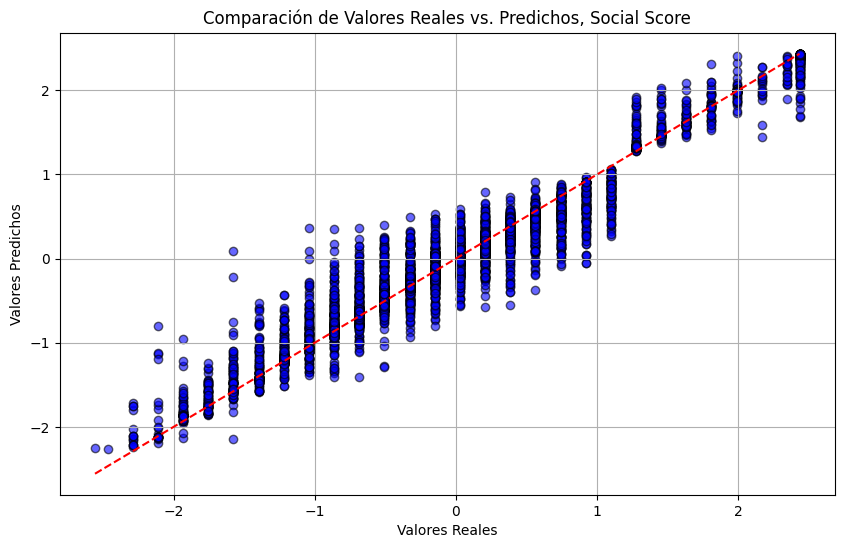

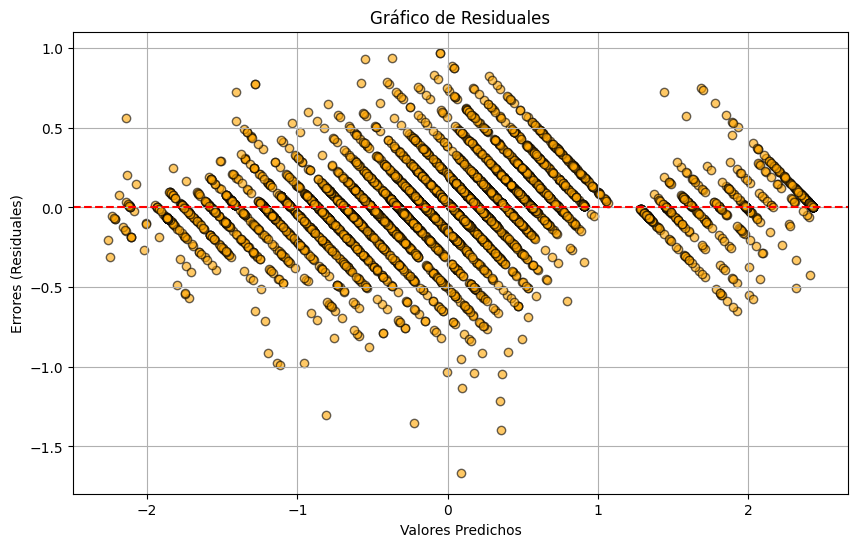

In [29]:
# Gráfico 1: Comparación entre valores reales y predichos
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.6, color='b', edgecolor='k')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='r', linestyle='--')
plt.xlabel("Valores Reales")
plt.ylabel("Valores Predichos")
plt.title("Comparación de Valores Reales vs. Predichos, Social Score")
plt.grid(True)
plt.show()

# Gráfico 2: Gráfico de Residuales
residuals = y_test - y_pred

plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.6, color='orange', edgecolor='k')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Valores Predichos")
plt.ylabel("Errores (Residuales)")
plt.title("Gráfico de Residuales")
plt.grid(True)
plt.show()